In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
#engine = create_engine("sqlite:///Resources/hawaii.sqlite")
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = (session.query(measurement.date).order_by(measurement.date.desc()).first())

recent_date

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


Text(0, 0.5, 'Inches')

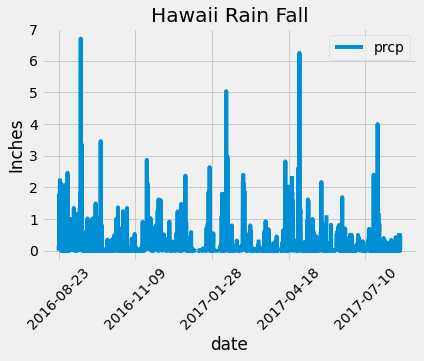

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year = dt.date(2017,8,23) - dt.timedelta(days=365)
last_year

# Perform a query to retrieve the data and precipitation scores
#recent_date_format = func.strftime('%y-%d-%m', recent_date)

precipitation = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= last_year).\
    order_by(measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_meas_df = pd.DataFrame(data=precipitation)
precip_meas_ind = precip_meas_df.set_index('date')

precip_meas_ind
# Sort the dataframe by date
precip_meas_sort = precip_meas_ind.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
plot = precip_meas_sort.plot(title="Hawaii Rain Fall", rot=45)
plot.set_ylabel("Inches")

In [61]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_meas_sort.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [63]:
# Design a query to calculate the total number stations in the dataset
station_total = session.query(station).count()

station_total

9

In [66]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_station = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [85]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
ID = most_active_station[0][0]
ID

sel = [func.min(measurement.tobs),
      func.max(measurement.tobs),
      func.avg(measurement.tobs)]

Temps = session.query(*sel).filter(measurement.station == ID).all()

min_temp = Temps[0][0]
max_temp = Temps[0][1]
avg_temp = Temps[0][2]

print(f"Lowest temperature at station {ID} was {min_temp}")
print(f"Highest temperature at station {ID} was {max_temp}")                
print(f"Average temperature at station {ID} was {avg_temp}")

Lowest temperature at station USC00519281 was 54.0
Highest temperature at station USC00519281 was 85.0
Average temperature at station USC00519281 was 71.66378066378067


Text(0.5, 0, 'Temperature')

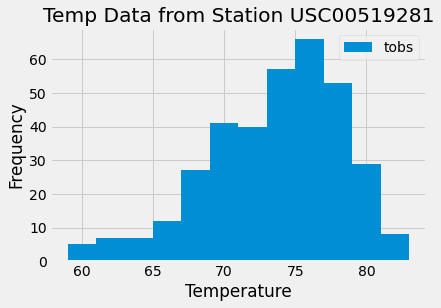

In [97]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station==ID).\
    filter(measurement.date >= last_year).\
    order_by(measurement.date.desc()).all()

station_df = pd.DataFrame(station_data)
station_ind = station_df.set_index('date')
station_sort = station_ind.sort_index(ascending=True)

plot = station_sort.plot(kind = 'hist', title = f"Temp Data from Station {ID}", bins=12)
plot.set_xlabel("Temperature")

# Close session

In [92]:
# Close Session
session.close()